In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from keras.layers.wrappers import Bidirectional 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
n_lstm_1 = 64 # lower
n_lstm_2 = 64 # new!
drop_lstm = 0.2

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip


x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

17473536/17464789 [==============================] - 0s 0us/step


In [4]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Bidirectional(LSTM(n_lstm_1, dropout=drop_lstm, return_sequences=True))) # retain temporal dimension
model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 128)          66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 804,993
Trainable params: 804,993
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath="/weights_stacked_bilstm.{epoch:02d}.hdf5")

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 324s 2s/step - loss: 0.5528 - accuracy: 0.6719 - val_loss: 0.2973 - val_accuracy: 0.8732
Epoch 2/4
196/196 [==============================] - 295s 2s/step - loss: 0.2355 - accuracy: 0.9114 - val_loss: 0.3209 - val_accuracy: 0.8658
Epoch 3/4
196/196 [==============================] - 295s 2s/step - loss: 0.1705 - accuracy: 0.9391 - val_loss: 0.3500 - val_accuracy: 0.8584
Epoch 4/4
196/196 [==============================] - 296s 2s/step - loss: 0.1247 - accuracy: 0.9571 - val_loss: 0.3534 - val_accuracy: 0.8592


In [11]:
model.load_weights("/weights_stacked_bilstm.04.hdf5") # zero-indexed

In [12]:
y_hat = model.predict_proba(x_valid)

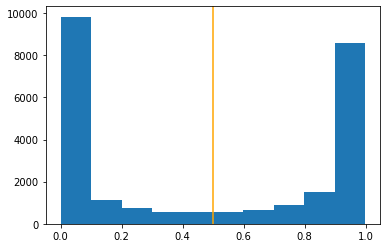

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'93.57'